In [97]:
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
import collections


In [98]:
def getGraphFromFile():
    graph = nx.read_edgelist('graph.txt', nodetype=int,
    data=(('weight',int),), create_using=nx.Graph())
    return graph

{(0, 1): Text(0.06801120527149412, 0.9726902362323717, '10'),
 (0, 2): Text(0.39029598149641426, -0.027254954100926987, '1'),
 (1, 3): Text(-0.3902959814964142, 0.027254954100927153, '1'),
 (3, 2): Text(-0.0680112052714941, -0.9726902362323715, '10')}

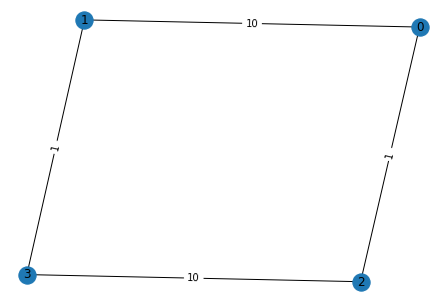

In [99]:
graph = getGraphFromFile()
pos = nx.spring_layout(graph)
nx.draw(graph,pos,with_labels=1)
labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

In [100]:
qubitsNumber = graph.number_of_nodes()
layersNumber = 3
shotsNumber = 100
device = qml.device("default.qubit", wires=qubitsNumber, shots=shotsNumber)

In [101]:
def U_b(beta):
    for qubit in range(qubitsNumber):
        qml.RX(2*beta, wires=qubit)

In [102]:
def U_c(gamma):
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        qml.CNOT(wires=[i,j])
        qml.RZ(weight*gamma, wires = j)
        qml.CNOT(wires=[i,j])

In [103]:
def compBasisMeasurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [104]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)

@qml.qnode(device)
def circuit(gammas, betas, edge=None):

    for i in range(0,qubitsNumber):
        qml.Hadamard(wires=i)

    for i in range(0,layersNumber):
        U_c(gammas[i])
        U_b(betas[i])

    if edge is None:
        return qml.sample(compBasisMeasurement(range(qubitsNumber)))

    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [105]:
def costFunction(params):
    gammas = params[0]
    betas = params[1]
    cost = 0
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        cost -= 0.5*weight*(1-circuit(gammas, betas, edge=[i,j]))
    return cost

In [106]:
def getMaxCutSolution(params):
    gammas = params[0]
    betas = params[1]
    outputDecimal = circuit(gammas, betas)
    occurrences = collections.Counter(outputDecimal)
    return occurrences

In [107]:
def getOptimizer(optimizerName="GradientDescent", stepSize=0.01):
    if optimizerName == "GradientDescent":
        return qml.GradientDescentOptimizer(stepsize=stepSize)
    if optimizerName == "Adam":
        return qml.AdamOptimizer(stepsize=stepSize)
    if optimizerName == "NesterovMomentum":
        return qml.NesterovMomentumOptimizer(stepsize=stepSize)
    if optimizerName == "Adagrad":
        return qml.AdagradOptimizer(stepsize=stepSize)

In [108]:
if __name__ == '__main__':
    params = 0.01*np.random.rand(2, layersNumber)
    optimizer = getOptimizer(optimizerName="Adam", stepSize=0.3)
    stepNumber = 200
    for i in range(stepNumber):
        params = optimizer.step(costFunction, params)
        print("Results in " + str(i) + " step: " + str(getMaxCutSolution(params)))
    print("Final results: " + str(getMaxCutSolution(params)))

Results in 0 step: Counter({12.0: 12, 15.0: 9, 11.0: 9, 7.0: 9, 3.0: 8, 13.0: 7, 6.0: 7, 4.0: 6, 2.0: 6, 1.0: 5, 8.0: 5, 14.0: 4, 5.0: 4, 0.0: 4, 9.0: 3, 10.0: 2})
Results in 1 step: Counter({5.0: 32, 10.0: 30, 11.0: 6, 14.0: 5, 2.0: 5, 4.0: 4, 8.0: 3, 6.0: 3, 13.0: 2, 9.0: 2, 1.0: 2, 7.0: 2, 15.0: 2, 0.0: 1, 3.0: 1})
Results in 2 step: Counter({15.0: 17, 0.0: 15, 10.0: 13, 12.0: 8, 4.0: 7, 5.0: 7, 11.0: 7, 13.0: 6, 1.0: 5, 7.0: 4, 3.0: 3, 2.0: 3, 8.0: 2, 6.0: 1, 14.0: 1, 9.0: 1})
Results in 3 step: Counter({9.0: 39, 6.0: 22, 10.0: 11, 5.0: 7, 2.0: 6, 11.0: 3, 7.0: 2, 13.0: 2, 4.0: 2, 15.0: 2, 1.0: 2, 14.0: 1, 12.0: 1})
Results in 4 step: Counter({12.0: 24, 3.0: 20, 0.0: 19, 15.0: 9, 2.0: 5, 7.0: 3, 6.0: 3, 11.0: 3, 13.0: 2, 8.0: 2, 14.0: 2, 1.0: 2, 5.0: 2, 10.0: 2, 4.0: 1, 9.0: 1})
Results in 5 step: Counter({0.0: 25, 3.0: 18, 15.0: 18, 12.0: 17, 10.0: 4, 13.0: 3, 8.0: 3, 4.0: 3, 1.0: 2, 2.0: 2, 7.0: 2, 11.0: 2, 14.0: 1})
Results in 6 step: Counter({0.0: 12, 10.0: 11, 9.0: 10, 15.0: 8